# Wordle Guesser

[Wordle](https://www.powerlanguage.co.uk/wordle/) is a popular word guessing game in which the player has six attempts at identifying a hidden 5-letter word. After each guess, the player receives color-coded feedback on each of the five letters of the guessed word: (1) a green letter indicates that this letter occurs in the hidden word at this position, (2) a yellow letter indicates that this letter occurs in the hidden word at a different position, (3) a gray letter doesn't appear in the hidden word.

In this notebook, I'm developing a 

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt

# Load possible words and list of letters ordered by frequency

In the following, I'm loading a list of possible words that are used in Wordle, as well as a list of letters sorted by how frequently they occur in the English language.

In [3]:
## List of possible words from FiveThirtyEight: 
# https://fivethirtyeight.com/features/when-the-riddler-met-wordle/

# Guessable words
# https://docs.google.com/spreadsheets/d/1KR5lsyI60J1Ek6YgJRU2hKsk4iAOWvlPLUWjAZ6m8sg/edit#gid=0
# all_words = pd.read_csv('https://docs.google.com/spreadsheets/d/1KR5lsyI60J1Ek6YgJRU2hKsk4iAOWvlPLUWjAZ6m8sg/gviz/tq?tqx=out:csv&sheet=Sheet1', header=None)[0]

# Mystery words
# https://docs.google.com/spreadsheets/d/1-M0RIVVZqbeh0mZacdAsJyBrLuEmhKUhNaVAI-7pr2Y/edit#gid=0
all_words = pd.read_csv('https://docs.google.com/spreadsheets/d/1-M0RIVVZqbeh0mZacdAsJyBrLuEmhKUhNaVAI-7pr2Y/gviz/tq?tqx=out:csv&sheet=Sheet1', header=None)[0]

# from https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html
#letters_ordered = ['e','t','a','i','n','o','s','h','r','d','l','u','c','m','f','w','y','g','p','b','v','k','q','j','x','z']
letters_ordered = ['e','a','r','i','o','t','n','s','l','c','u','d','p','m','h','g','b','f','y','w','k','v','x','z','j','q']


# Function definitions

In [4]:
# Returns character-wise evaluation of result (g = green, x = gray, y = yellow)
def evaluate_guess(guess_str, actual_str):
    res_str = ''
    for char_id in np.arange(5):
        this_char_res = 'x'
        if guess_str[char_id] in actual_str:
            this_char_res = 'y'
            if guess_str[char_id] == actual_str[char_id]:
                this_char_res = 'g'
        res_str += this_char_res
    return res_str

# Returns list of remaining words given prior results
def remaining_words(prior_guesses, prior_res):
    # Table with known information about each letter and the response from prior guesses
    know = pd.DataFrame({ 'letter': list(''.join(prior_guesses)),
                          'response': list(''.join(prior_res)),
                          'position': list(np.arange(1,6)) * len(prior_guesses)
                         })  
    
    # Excluded and yellow letters (excluded letters not counted if they also show up as green somewhere)
    excluded_letters = [l for l in list(know[know['response']=='x']['letter'].unique()) if l not in list(know[know['response']=='g']['letter'].unique())]
    yellow_letters = list(know[know['response']=='y']['letter'].unique())
    
    # Only words that don't contain excluded letters
    rm = [w for w in all_words if not any(l in w for l in excluded_letters)]
    
    # Only words that contain all yellow letters
    rm = [w for w in rm if (yellow_letters == []) | all(l in w for l in yellow_letters)]
    
    ## Only words that have green letters in the right place
    # positions with known letter
    green_pos = know[know['response']=='g'].groupby('position', as_index=False).max()[['position','letter']]

    # For each known position, filter only words that have the right letter in that position
    for p, l in green_pos.itertuples(index=False):
        rm = [w for w in rm if w[p-1] == l]    
        
    ## Only words that don't have yellow letters in the same place as previously
    # positions with yellow letter
    yellow_pos = know[know['response']=='y'].groupby('position', as_index=False).max()[['position','letter']]

    # For each known position, filter only words that don't have the yellow letter in that position
    for p, l in yellow_pos.itertuples(index=False):
        rm = [w for w in rm if w[p-1] != l]         
        
    # Exclude words that were alrady tried
    rm = [w for w in rm if w not in prior_guesses]
    
    # Add word score and number of unique letters and return as randomized dataframe
    rm = pd.DataFrame({'word': rm})
    rm['score'] = rm['word'].map(word_score)
    rm['unique_letters'] = rm['word'].map(lambda x: len(set(x)))
    rm = rm.sample(frac = 1.)
        
    return rm

# Calculate the score for a word based on letter frequency where a high score indicates a word with many frequently occuring letters
def word_score(word):
    word_score = 0
    for c in word:
        word_score += len(letters_ordered) - letters_ordered.index(c)
    return word_score

# Simulates n_samples games of wordle in which the guessing_function is used to determine the next guesses
def benchmark_method(guessing_function, n_samples, starting_word = 'irate'):
    sim_attempts = []

    for i in np.arange(100):
        # Choose actual word
        actual_str = random.choice(all_words)
        #print(actual_str)
        # First guess
        n_attempts = 1
        guesses = [starting_word]
        res = [evaluate_guess(starting_word, actual_str)]

        # check if this was the right word
        if res[-1] == 'ggggg':
            break;    

        for n_attempts in np.arange(2,11):

            # Next guesses
            guesses.append(guessing_function(guesses, res))
            res.append(evaluate_guess(guesses[-1], actual_str))

            #print(guesses[-1], res[-1])

            # check if this was the right word
            if res[-1] == 'ggggg':
                break;

        sim_attempts.append(n_attempts)    
    
    return sim_attempts

    
    

## First word: 'irate'

The first guess cannot rely on any feedback and therefore can be the same in each game. It has to be a word from the list of all words and I'm choosing one that has 5 different letters so as to maximize the letters that can be excluded after the first try. Out of the words that match these criteria, I'm choosing the one with the highest word score.

In [5]:
tmp = remaining_words([], [])
tmp = tmp.loc[tmp['unique_letters']==5]
tmp.sort_values('score', ascending=False).head()

,word,score,unique_letters
1043,irate,119,5
105,arise,117,5
1534,raise,117,5
108,arose,116,5
1545,ratio,115,5


## Manual

In [6]:
# Pick a hidden word
actual_str = random.choice(all_words)

In [7]:
# Make a guess at the hidden word
evaluate_guess('varia', actual_str)

'xggxy'

## 1. Randomly choosing from remaining possible words

In [8]:
prior_guesses = ['irate', 'furan', 'damar', 'achar', 'alvar']
prior_res     = ['xyyxx', 'xxygx', 'xxxgg', 'xxxgg', 'xyxgg']

In [9]:
def suggest_next_random(prior_guesses, prior_res):
    return remaining_words(prior_guesses, prior_res).iloc[0,0]

In [10]:
# pick first from this list
remaining_words(prior_guesses, prior_res).sample(frac = 1)

,word,score,unique_letters
1,solar,108,5
0,polar,103,5


### Quantifying

In [175]:
benchm1 = benchmark_method(guessing_function = suggest_next_random, n_samples = 100)

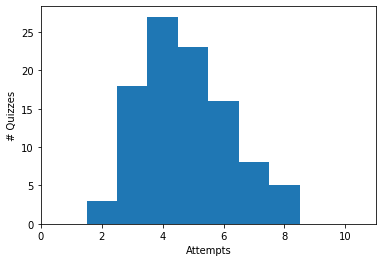

In [176]:
plt.hist(benchm1, bins=10, range=(0.5, 10.5))
plt.xlabel('Attempts')
plt.ylabel('# Quizzes')
plt.show()

In [177]:
np.median(benchm1)

5.0

In [178]:
(np.array(benchm1) <= 6).mean()

0.87

## 2. Choose from remaining words by score

In [15]:
prior_guesses = ['irate','tonic']
prior_res     = ['yxxyx','ygyyx']

In [16]:
def suggest_next_by_score(prior_guesses, prior_res):
    return remaining_words(prior_guesses, prior_res).sort_values('score', ascending = False).iloc[0,0]

In [17]:
# pick first from this list
remaining_words(prior_guesses, prior_res).sort_values('score', ascending = False)

,word,score,unique_letters
1,point,100,5
0,joint,88,5


### Quantifying

In [217]:
benchm2 = benchmark_method(guessing_function = suggest_next_by_score, n_samples = 100)

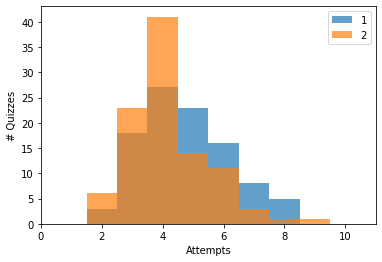

In [218]:
plt.hist(benchm1, bins=10, range=(0.5, 10.5), alpha=0.7, label='1')
plt.hist(benchm2, bins=10, range=(0.5, 10.5), alpha=0.7, label='2')
plt.xlabel('Attempts')
plt.legend()
plt.ylabel('# Quizzes')
plt.show()

In [219]:
np.median(benchm2)

4.0

In [220]:
(np.array(benchm2) <= 6).mean()

0.95